In [2]:
# allow plots to appear in the notebook
%matplotlib inline 
# autoreload allows some modules to be reloaded automatically when functions are called.
%load_ext autoreload
# auto-reload functions from specified python modules (using %aimport)
%autoreload 1 
import matplotlib.pyplot as plt
import sys
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
#!pip install seaborn
import seaborn as sns
import math
import random
import itertools
import logging
import re
import json
from Bio import SeqIO
import time

In [3]:
%aimport Designs    
import rna_draw
## my version of nupack python stuff is slightly modified
from nupack import *
from Bio.Seq import Seq
# https://github.com/YesselmanLab/rna_draw
import rna_draw as rd

# This is for the complex

The structure for Three Way Junction:

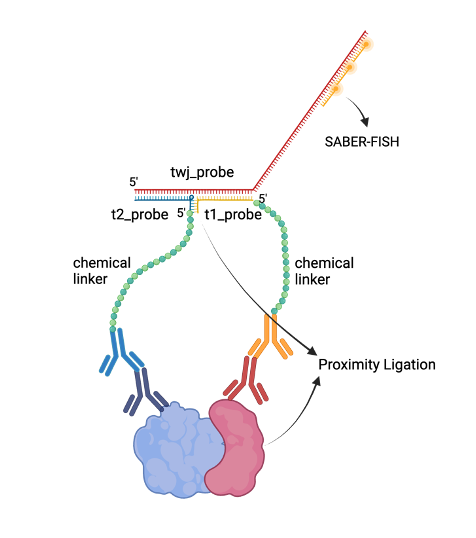

In [4]:
data = []
constraints = {}
with open("42mer_k14_probe.fa") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        constraints[record.id] = str(record.seq)
library = list(constraints.values())

In [5]:
def findall_overlapped(r,s,rlen):
    res = []                     # Resulting list
    reg = r'^{}$'.format(r)      # Regex must match full string
    for q in range(len(s)-rlen+1):      # Iterate over all chars in a string
        cur = s[q:q+rlen]         # Currently tested slice

        if re.match(reg, cur): # If there is a full slice match
            res.append(cur)    # Append it to the resulting list
    return res

rex = '[GC].{18}[TC].G.{2}[GC]{2}'

candidate_boundary = 500

s1_candidates = sum([findall_overlapped(rex,s,26) for s in library],[])
s1_candidates

['CATCGTTGGCGTAACATCGTTGGCGC',
 'CGACGTAGTAGCTCCAACGTAGTAGC',
 'CGTAGTAGCTCCAACGTAGTAGCTCG',
 'GTAGCTCCAACGTAGTAGCTCGTACG',
 'CTCAACTGTAGCAGCTGTACTGTAGC',
 'GTCGATAGGACCTCGTCAATAGGACC',
 'CTCGATAGCACGTGCTCAATAGCACG',
 'CTCAATAGCACGTGCTGTATAGCACG',
 'GGAAATCGTAGCCTGATAATCGTAGC',
 'CTACACTGTCGGTACCAGACTGTCGG',
 'CAATTCCGTAGGCAGTATTCCGTAGG',
 'CTGGTTAGACCCAACTGGTTAGACCG',
 'CGATTCAGGACCTGCAATTCAGGACC',
 'CAATGTTGACCCGAGTATGTTGACCC',
 'CACGATCGAGCGTTCACAATCGAGCG',
 'CACAATCGAGCGTTCAGTATCGAGCG',
 'CAACTTCGAGGCTAGTACTTCGAGGC',
 'CATGACTGACCGTTGATGACTGACCG',
 'GATGACTGACCGTTAATGACTGACCG',
 'CTGTATAGCTGGACCTGCATAGCTGG',
 'CGAGGTAGTACCTTCGAGGTAGCACC',
 'GAGGTTCCAACCTAGAGGTTCGTACC',
 'CCTGACAGTGGTATCCTGACAGTGGC',
 'GTACCTTGGCGTAAGTACCTTGGCGC',
 'CGAGTTACAACGCTCGAGTTAGTACG',
 'CCTTATGGGCGTAACCTTATGGGCGC',
 'CCAATTGGAGCCATCGTATTGGAGCC',
 'CAACTTAGTCGGACGTACTTAGTCGG',
 'CTTAGTCGGACGTACTTAGTCGGACG',
 'CACGATCGGACGTTCACAATCGGACG',
 'CATGCCAGTGGTATCATGCCAGTGGC',
 'CGATTCCGAGCGATCAATTCCGAGCG',
 'GGCTTT

In [6]:
d1a = Domain('NNNNNNNNNNNNNNNNNNNYN',name='1a')
d1b = Domain('GNNNN',name='1b')
s1 = TargetStrand([d1a,d1b], name = 'Strand 1')
d2b = Domain('TT',name='bulge')
d3b = Domain('N21',name='3b')
s2 = TargetStrand([~d1b,d2b,d3b],name='Strand 2')

# Now for the switch

In [7]:
#complementary to t2
d3t = Domain('SNNNN',name='toe')
d3s_5 = Domain('N16',name='stem_5p')
#complementary to t1
d3s_3 = Domain('N9',name='stem_3p')
d3l = Domain('N12',name='loop')

s3 = TargetStrand( [ d3t, d3s_5, d3s_3, d3l, ~ d3s_3, ~ d3s_5], name='HP switch probe')

## Constraints

In [8]:
random.sample(s1_candidates,candidate_boundary)
l1 = Library(s1,[random.sample(s1_candidates,candidate_boundary)])
l2 = Window([d3t,d3s_5],random.sample(library,candidate_boundary))

In [9]:
twj = TargetComplex([s1,s2,s3],
                   '(26+)5.2(21+)42.25',
                   name = 'TWJ attempt 1')

HP = TargetComplex([s3],
                  '.5(25.12)25',
                  name ='HP')

S1 = TargetComplex([s1],
                   '.26',name='S1')

S2 = TargetComplex([s2],
                   '.28',name='S2')

## Let's think about the switch

In [10]:
my_model = Model(material='dna',sodium=.390,celsius=42)

In [11]:
with open("data.json", "r") as file:
    data = json.load(file)

In [12]:
t1 = TargetTube(on_targets={twj: 1e-8}, name='t1',
                off_targets=SetSpec(max_size=3, include=[[s3],[s1,s3],[s2,s3]]))

t2 = TargetTube(on_targets={HP: 1e-8, 
                            S1: 1e-8}, 
                name='t2',
                off_targets=SetSpec(max_size=2, include=[[s1,s3]]))


t3 = TargetTube(on_targets={HP: 1e-8,
                            S2: 1e-8},
                name='t3',
               off_targets=SetSpec(max_size=2, include=[[s2,s3]]))

In [13]:
div1 = Diversity(word=4, types=2)
div2 = Diversity(word=6, types=3)
div3 = Diversity(word=10, types=4)
my_tubes = [t1,t2,t3]

## Run!

In [186]:
results = list()
sample_times = []
ntrials = 4

for i in range(2):
    time1 = time.perf_counter()
    l1 = Library(s1,[random.sample(s1_candidates,candidate_boundary)])
    l2 = Window([d3t,d3s_5],random.sample(library,candidate_boundary))
    my_design = tube_design(tubes=my_tubes,
                            hard_constraints=[div1,div2,l1,l2], soft_constraints=[],
                            defect_weights=None, options=None, model=my_model)
    print(f'round {i}')
    my_results = my_design.run(trials=ntrials)
    for j in range(len(my_results)):
        my_results[j].save(f'results/my_results_{i}_{j}.o')
    results = results + my_results
    sample_times = sample_times +  [(time.perf_counter() - time1)]
    print(f"sample time {i}: {sample_times[i]}")
    
len(results)

round 0
sample time 0: 77.16748812503647
round 1
sample time 1: 61.06007104192395


8

In [187]:
# a sorting function to sort by the total ensemble defect.
def ensdefects(r):
    return r.defects.weighted_ensemble_defect

# a sorting function to sort by the total complex defect
def complexdefects(r):
    return sum(r.defects.complexes.defect)

results.sort(key=complexdefects)

[complexdefects(r) for r in results]

[24.843667850512745,
 27.57403577026146,
 29.092026350155177,
 30.646628567369206,
 31.75594648470289,
 32.2003830171756,
 32.51287956385141,
 33.59807693699386]

In [181]:
results_of_interest = results[6]
t1_designed = results_of_interest.to_analysis[t1]
twj_seq = "+".join([str(s) for s in results_of_interest.to_analysis.strands.values()])
results_of_interest

Domain,Sequence
1a,CATGTCGGCTGTAACATGTCG
1b,GCTGC
1b*,GCAGC
3b,GTTACCGACCATGAGTTTGCG
bulge,TT
loop,ACAGCCGACATG
stem_3p,CGACATGTT
stem_3p*,AACATGTCG
stem_5p,ACTCATGGTCGGTAAC
stem_5p*,GTTACCGACCATGAGT


In [182]:
domains = {k.name: str(v) for k,v in my_results[0].domains.items()}
hp_seq = domains['toe'] + domains['stem_5p'] + domains['stem_3p'] + domains['loop'] + domains['stem_3p*'] + domains['stem_5p*']

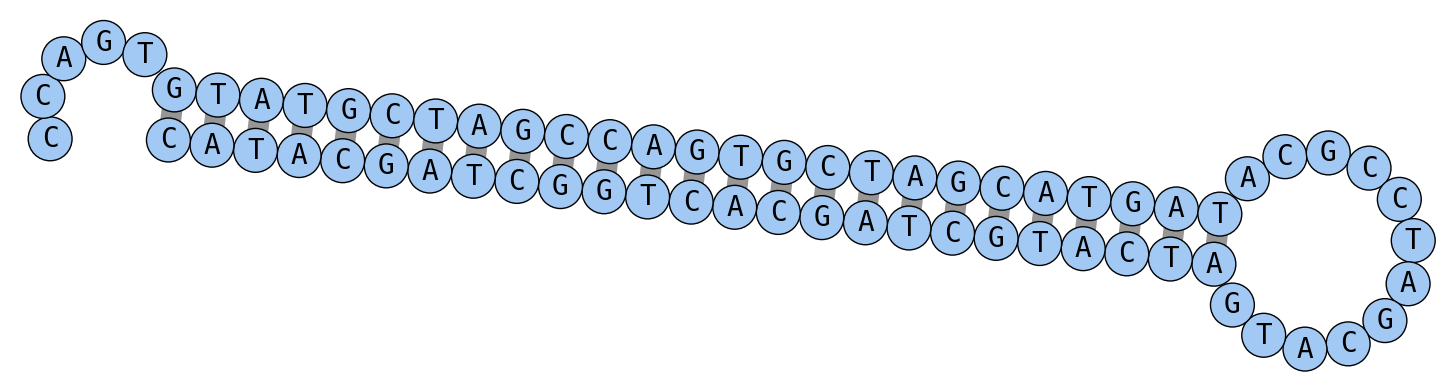

In [183]:
tube_results = complex_analysis(t1_designed, compute = ['pfunc','mfe'], model=my_model)
hp_ss = tube_results['(HP switch probe)'].mfe[0].structure.__str__()

rd.rna_draw(ss = hp_ss,
            seq = hp_seq,
            render_type='strand',color_palette='pastel')

In [184]:
tube_analysis([t1_designed], compute=['pfunc','mfe'], model=my_model)

Complex,Pfunc,ΔG (kcal/mol),MFE (kcal/mol)
(HP switch probe),8.2003e+17,-25.832,-25.053
(Strand 1),1.7318e+1,-1.786,-0.923
(Strand 2),8.5665e+0,-1.345,0.000
(HP switch probe+HP switch probe),2.6490e+39,-56.848,-55.520
(Strand 1+HP switch probe),1.3154e+24,-34.780,-32.155
(Strand 1+Strand 1),6.8015e+6,-9.853,-8.598
(Strand 2+HP switch probe),9.3106e+24,-36.005,-33.225
(Strand 2+Strand 1),2.3476e+8,-12.071,-9.672
(Strand 2+Strand 2),2.9823e+6,-9.336,-7.012
(HP switch probe+HP switch probe+HP switch probe),6.8813e+60,-87.728,-84.562


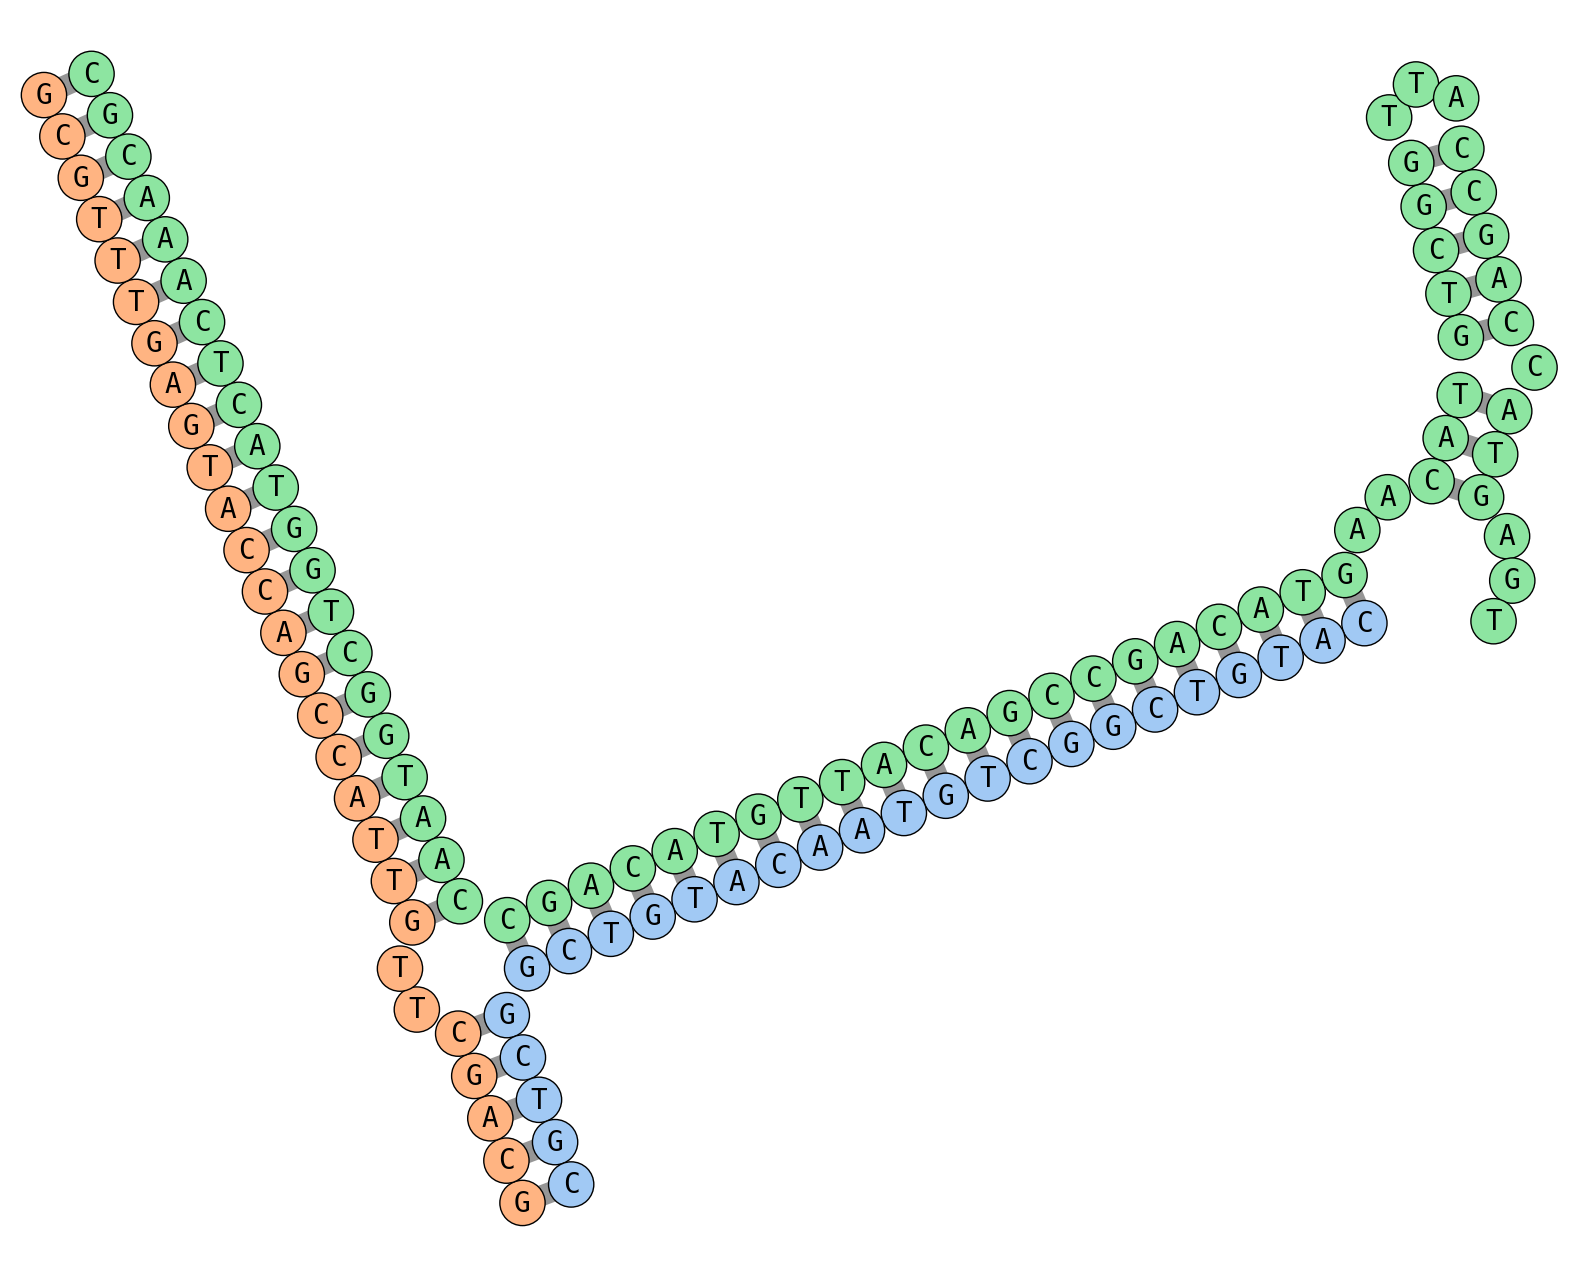

In [185]:
twj_ss =  tube_results['(Strand 1+Strand 2+HP switch probe)'].mfe[0].structure.__str__()

rd.rna_draw(ss = twj_ss,
            seq=twj_seq,
            render_type='strand',color_palette='pastel')

In [147]:
sequence = [str(s) for s in list(results_of_interest.to_analysis.strands.values())]
sequence = ','.join(sequence)

In [148]:
tks = list(results_of_interest.to_analysis.strands.keys())

ts1 = results_of_interest.to_analysis.strands[tks[0]]
ts2 = results_of_interest.to_analysis.strands[tks[1]]
ts3 = results_of_interest.to_analysis.strands[tks[2]]
c13 = Complex([ts1,ts3])
c23 = Complex([ts2,ts3])

In [149]:
Tube123 = Tube(strands={ts1: 1e-8,
                        ts2: 1e-8,
              ts3: 1e-8},
    complexes = SetSpec(max_size=3),
    name='1+2+3')

Tube13 = Tube(strands={ts1: 1e-8,
              ts3: 1e-8},
    complexes = SetSpec(max_size=2),
    name='1+3')

Tube23 = Tube(strands={ts2: 1e-8,
              ts3: 1e-8},
    complexes = SetSpec(max_size=2),
    name='2+3')

In [150]:
result = tube_analysis(tubes=[Tube123,Tube13,Tube23],
                          model=my_model,
                          compute=['pfunc','mfe'])
result

Complex,Pfunc,ΔG (kcal/mol),MFE (kcal/mol)
(HP switch probe),3.9219e+16,-23.928,-22.992
(Strand 1),1.6761e+1,-1.765,-0.831
(Strand 2),8.1707e+0,-1.315,0.000
(HP switch probe+HP switch probe),7.1892e+36,-53.148,-51.008
(HP switch probe+Strand 1),5.5143e+22,-32.793,-30.339
(HP switch probe+Strand 2),1.4405e+25,-36.279,-32.756
(Strand 1+Strand 1),1.7089e+7,-10.430,-9.088
(Strand 1+Strand 2),2.5870e+8,-12.131,-9.443
(Strand 2+Strand 2),4.6660e+6,-9.617,-7.526
(HP switch probe+HP switch probe+HP switch probe),1.1324e+57,-82.272,-78.350


In [151]:
[str(s) for s in list(results_of_interest.to_analysis.strands.values())]

['CGATCTTGGCGTAACGATCTTGGCGC',
 'GCGCCTTACCCGTGAGACTATTGCCGTG',
 'CACGGCAATAGTCTCACGGGTAAGATCGTTACGCCAAGATCGAACGATCTTACCCGTGAGACTATTG']

In [152]:
complex = [x.name for x in list(result[Tube123].complex_concentrations.keys())]
conc = list(result[Tube123].complex_concentrations.values())

my_conc = dict(zip(complex, conc))

print(my_conc)   

{'(HP switch probe)': 1.3713636425558706e-09, '(HP switch probe+HP switch probe)': 1.5972184743541938e-16, '(HP switch probe+HP switch probe+HP switch probe)': 1.5985582303610677e-23, '(HP switch probe+HP switch probe+Strand 1)': 2.7658976387014114e-21, '(HP switch probe+HP switch probe+Strand 2)': 5.831238109527886e-17, '(HP switch probe+Strand 1)': 2.86975836823673e-15, '(HP switch probe+Strand 1+Strand 1)': 7.756521043921207e-21, '(HP switch probe+Strand 1+Strand 2)': 8.627096960490042e-09, '(HP switch probe+Strand 2)': 1.5360849292590603e-12, '(HP switch probe+Strand 2+Strand 1)': 3.8387585895451224e-20, '(HP switch probe+Strand 2+Strand 2)': 6.114155626033565e-18, '(Strand 1)': 1.3728313825790156e-09, '(Strand 1+Strand 1)': 2.083248052621509e-15, '(Strand 1+Strand 1+Strand 1)': 4.081085566033137e-21, '(Strand 1+Strand 1+Strand 2)': 1.457143509120332e-19, '(Strand 1+Strand 2)': 6.462007905160388e-14, '(Strand 1+Strand 2+Strand 2)': 3.486206943198452e-19, '(Strand 2)': 1.37129748670

In [153]:
off_complex_1 = [x.name for x in list(result[Tube13].complex_concentrations.keys())]
off_conc_1 = list(result[Tube13].complex_concentrations.values())

my_conc_13 = dict(zip(off_complex_1, off_conc_1))

print(my_conc_13)

{'(HP switch probe)': 9.999830593103839e-09, '(HP switch probe+HP switch probe)': 8.492671927921287e-15, '(HP switch probe+Strand 1)': 1.524234977381405e-13, '(Strand 1)': 9.999626516566843e-09, '(Strand 1+Strand 1)': 1.1052846702178974e-13}


In [154]:
off_complex_2 = [x.name for x in list(result[Tube23].complex_concentrations.keys())]
off_conc_2 = list(result[Tube23].complex_concentrations.values())

my_conc_23 = dict(zip(off_complex_2, off_conc_2))

print(my_conc_23)

{'(HP switch probe)': 9.919610337769663e-09, '(HP switch probe+HP switch probe)': 8.356959304022575e-15, '(HP switch probe+Strand 2)': 8.03729541229777e-11, '(Strand 2)': 9.919377119091789e-09, '(Strand 2+Strand 2)': 1.2496010284424765e-13}


In [157]:
print(my_conc["(HP switch probe+Strand 1+Strand 2)"])

8.627096960490042e-09


In [158]:
print(my_conc_13["(HP switch probe+Strand 1)"])

1.524234977381405e-13


In [159]:
print(my_conc_23["(HP switch probe+Strand 2)"])

8.03729541229777e-11


In [160]:
data.append({ "S1": sequence[:26],
             "S2": sequence[27:55],
             "S3": sequence[56:],
            "Complex result":my_conc["(HP switch probe+Strand 1+Strand 2)"],
             "HP switch probe + Strand 1":my_conc_13["(HP switch probe+Strand 1)"],
             "HP switch probe":my_conc_13["(HP switch probe)"],
             "Strand 1":my_conc_13["(Strand 1)"],
             "HP switch probe + Strand 2":my_conc_23["(HP switch probe+Strand 2)"],
             "HP switch probe":my_conc_23["(HP switch probe)"],
             "Strand 2":my_conc_23["(Strand 2)"]
            })

### Data review

In [161]:
my_data = results[1].load('results/my_results_1_1.o')
print(my_data)

Domain results:
  Domain              Sequence
      1a CGATCTTGGCGTAACGATCTT
      1b                 GGCGC
     1b*                 GCGCC
      3b ACCCGTGAGACTATTGCCGTG
   bulge                    TT
    loop          ACGCCAAGATCG
 stem_3p             AAGATCGTT
stem_3p*             AACGATCTT
 stem_5p      CAATAGTCTCACGGGT
stem_5p*      ACCCGTGAGACTATTG
     toe                 CACGG

Strand results:
         Strand                                                            Sequence
       Strand 1                                          CGATCTTGGCGTAACGATCTTGGCGC
       Strand 2                                        GCGCCTTACCCGTGAGACTATTGCCGTG
HP switch probe CACGGCAATAGTCTCACGGGTAAGATCGTTACGCCAAGATCGAACGATCTTACCCGTGAGACTATTG

Objective function:
          Objective type Value
Weighted ensemble defect 0.125

Ensemble defect: 0.125

      Complex Complex defect (nt) Normalized complex defect
           HP                3.43                    0.0512
TWJ attempt 1                9.

## DataFrame

In [163]:
pd.DataFrame.from_dict(data)

,S1,S2,S3,Complex result,HP switch probe + Strand 1,HP switch probe,Strand 1,HP switch probe + Strand 2,Strand 2
0,CTCAGTAGGCGTATCTCAGTAGGCGC,GCGCCTTTGACGGGTCTACATCGACGGG,CCCGTCGATGTAGACCCGTCATACTGAGATACGCCTACTGAGATCT...,7.391609e-09,6.547110e-15,9.987431e-09,9.999933e-09,1.256436e-11,9.987200e-09
1,CATCGTTGCGGTAACATCGTTGCGGC,GCCGCTTACCCGTGAAGACTTTGCCGTG,CACGGCAAAGTCTTCACGGGTAACGATGTTACCGCAACGATGAACA...,8.792114e-09,4.380046e-14,9.955502e-09,9.999911e-09,4.447850e-11,9.955463e-09
2,GATTCCAGTGCGACAATTCCAGTGCG,CGCACTTTCGGCTGATTGAACTCGGCTG,CAGCCGAGTTCAATCAGCCGATGGAATTGTCGCACTGGAATCACAA...,8.224017e-09,8.886310e-15,9.963127e-09,9.999949e-09,3.686613e-11,9.963085e-09
3,CGATTCAGCGGCATCAATTCAGCGGC,GCCGCTTCAGGTGCTCATTGACAGGTGC,GCACCTGTCAATGAGCACCTGTGAATTGATGCCGCTGAATCGATCA...,8.628771e-09,9.085301e-15,9.992813e-09,9.999963e-09,7.181180e-12,9.992771e-09
4,CGATTCAGCGGCATCAATTCAGCGGC,GCCGCTTAGGGCTCAATAGTCAGGGCTC,GAGCCCTGACTATTGAGCCCTTGAATTGATGCCGCTGAATCGATCA...,8.254695e-09,3.900246e-14,9.978780e-09,9.999934e-09,2.121148e-11,9.978753e-09
5,GAGACTTGCCGTATGAGACTTGCCGC,GCGGCTTTATGGGCTACACATTTCGGGC,GCCCGAAATGTGTAGCCCATAAAGTCTCATACGGCAAGTCTCATGA...,8.275840e-09,1.602871e-14,9.945677e-09,9.999941e-09,5.430997e-11,9.945637e-09
6,GAGTTCAGCCGTATGAGTTCAGCCGC,GCGGCTTATTGGGCAACTGTCATCGGGC,GCCCGATGACAGTTGCCCAATTGAACTCATACGGCTGAACTCATGA...,8.574397e-09,1.508594e-14,9.972858e-09,9.999951e-09,2.712873e-11,9.972818e-09
7,CGATTCAGCGGCATCAATTCAGCGGC,GCCGCTTAGCCGTCATTGTAGAGCCGTC,GACGGCTCTACAATGACGGCTTGAATTGATGCCGCTGAATCGATCA...,9.136954e-09,1.889244e-14,9.962576e-09,9.999954e-09,3.740038e-11,9.962524e-09
8,CGATTCGGACGCATCAATTCGGACGC,GCGTCTTAGGCGTCATTGTCAAGGCGTC,GACGCCTTGACAATGACGCCTCGAATTGATGCGTCCGAATCGATCA...,8.467231e-09,2.389637e-14,9.962991e-09,9.999910e-09,3.697403e-11,9.962972e-09
9,CTGACTTGACGCGACTTACTTGACGC,GCGTCTTATTGGGCACTCATGATCGGGC,GCCCGATCATGAGTGCCCAATAAGTAAGTCGCGTCAAGTCAGGACT...,7.852529e-09,1.204640e-14,9.952677e-09,9.999607e-09,4.730793e-11,9.952515e-09


In [164]:
with open("data.json", "w") as file:
    json.dump(data, file)

In [165]:
data

[{'S1': 'CTCAGTAGGCGTATCTCAGTAGGCGC',
  'S2': 'GCGCCTTTGACGGGTCTACATCGACGGG',
  'S3': 'CCCGTCGATGTAGACCCGTCATACTGAGATACGCCTACTGAGATCTCAGTATGACGGGTCTACATCG',
  'Complex result': 7.391609269542693e-09,
  'HP switch probe + Strand 1': 6.547110408026785e-15,
  'HP switch probe': 9.987431321858523e-09,
  'Strand 1': 9.999933034569956e-09,
  'HP switch probe + Strand 2': 1.2564359772064343e-11,
  'Strand 2': 9.987199581868366e-09},
 {'S1': 'CATCGTTGCGGTAACATCGTTGCGGC',
  'S2': 'GCCGCTTACCCGTGAAGACTTTGCCGTG',
  'S3': 'CACGGCAAAGTCTTCACGGGTAACGATGTTACCGCAACGATGAACATCGTTACCCGTGAAGACTTTG',
  'Complex result': 8.792114178678454e-09,
  'HP switch probe + Strand 1': 4.3800463590971366e-14,
  'HP switch probe': 9.955502285567816e-09,
  'Strand 1': 9.999911240991614e-09,
  'HP switch probe + Strand 2': 4.447850444672574e-11,
  'Strand 2': 9.955463381416308e-09},
 {'S1': 'GATTCCAGTGCGACAATTCCAGTGCG',
  'S2': 'CGCACTTTCGGCTGATTGAACTCGGCTG',
  'S3': 'CAGCCGAGTTCAATCAGCCGATGGAATTGTCGCACTGGAATCACAATTCCATC